In [1]:
%load_ext autoreload
%autoreload 2

In [64]:
kernel_mode = False

import sys
if kernel_mode:
    sys.path.insert(0, "../input/pytorch-lightning")
    sys.path.insert(0, "../input/hpa-bestfitting")
    sys.path.insert(0, "../input/hpa-cell-segmentation")

import sys
import argparse
from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import time
import random
import math
import pickle
from pickle import dump, load
import glob
import time

import torch
import torch.optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.nn import DataParallel
import torch.nn.functional as F
from torch.autograd import Variable

from config.config import *
from utils.common_util import *
from networks.imageclsnet import init_network
from datasets.protein_dataset import ProteinDataset
from utils.augment_util import *
from datasets.tool import *

import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import classification

import cv2
from PIL import Image
import imagehash

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None

import gc
gc.enable()

rand_seed = 1120

print(f"PyTorch Version: {torch.__version__}")
print(f"PyTorch Lightning Version: {pl.__version__}")

PyTorch Version: 1.6.0+cu101
PyTorch Lightning Version: 1.1.1


In [3]:
# All label names in the public HPA and their corresponding index.
all_locations = dict({
    "Nucleoplasm": 0,
    "Nuclear membrane": 1,
    "Nucleoli": 2,
    "Nucleoli fibrillar center": 3,
    "Nuclear speckles": 4,
    "Nuclear bodies": 5,
    "Endoplasmic reticulum": 6,
    "Golgi apparatus": 7,
    "Intermediate filaments": 8,
    "Actin filaments": 9,
    "Focal adhesion sites": 9,
    "Microtubules": 10,
    "Mitotic spindle": 11,
    "Centrosome": 12,
    "Centriolar satellite": 12,
    "Plasma membrane": 13,
    "Cell Junctions": 13,
    "Mitochondria": 14,
    "Aggresome": 15,
    "Cytosol": 16,
    "Vesicles": 17,
    "Peroxisomes": 17,
    "Endosomes": 17,
    "Lysosomes": 17,
    "Lipid droplets": 17,
    "Cytoplasmic bodies": 17,
    "No staining": 18,
    # markpeng
    "Rods & rings": 18,
})

In [4]:
dataset_folder = "/workspace/Kaggle/HPA/hpa_2020"
bestfitting_folder = "/workspace/Github/HPA-competition-solutions/bestfitting"
test_image_folder = f"{dataset_folder}/test/"
NUC_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_nuclei_v1.pth"
CELL_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_cell_3ch_v1.pth"

image_size = 768
crop_size = 512

In [5]:
!ls {dataset_folder}

inference	       test	       train	  train_tfrecords
sample_submission.csv  test_tfrecords  train.csv


In [6]:
train_df = pd.read_csv(f"{dataset_folder}/train.csv")
submit_df = pd.read_csv(f"{dataset_folder}/sample_submission.csv")

In [7]:
print(train_df.shape)
train_df.head()

(21806, 2)


,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [8]:
print(submit_df.shape, submit_df.ImageWidth.min(), submit_df.ImageWidth.max())
submit_df.head()

(559, 4) 1728 3072


,ID,ImageWidth,ImageHeight,PredictionString
0,0040581b-f1f2-4fbe-b043-b6bfea5404bb,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
1,004a270d-34a2-4d60-bbe4-365fca868193,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
2,00537262-883c-4b37-a3a1-a4931b6faea5,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
3,00c9a1c9-2f06-476f-8b0d-6d01032874a2,2048,2048,0 1 eNoLCAgIMAEABJkBdQ==
4,0173029a-161d-40ef-af28-2342915b22fb,3072,3072,0 1 eNoLCAgIsAQABJ4Beg==


## Utility Functions

In [ ]:
# Reference: https://www.kaggle.com/dschettler8845/hpa-cellwise-classification-inference/notebook
def binary_mask_to_ascii(mask, mask_val=1):
    """Converts a binary mask into OID challenge encoding ascii text."""
    mask = np.where(mask == mask_val, 1, 0).astype(np.bool)

    # check input mask --
    if mask.dtype != np.bool:
        raise ValueError(
            f"encode_binary_mask expects a binary mask, received dtype == {mask.dtype}"
        )

    mask = np.squeeze(mask)
    if len(mask.shape) != 2:
        raise ValueError(
            f"encode_binary_mask expects a 2d mask, received shape == {mask.shape}"
        )

    # convert input mask to expected COCO API input --
    mask_to_encode = mask.reshape(mask.shape[0], mask.shape[1], 1)
    mask_to_encode = mask_to_encode.astype(np.uint8)
    mask_to_encode = np.asfortranarray(mask_to_encode)

    # RLE encode mask --
    encoded_mask = coco_mask.encode(mask_to_encode)[0]["counts"]

    # compress and base64 encoding --
    binary_str = zlib.compress(encoded_mask, zlib.Z_BEST_COMPRESSION)
    base64_str = base64.b64encode(binary_str)
    return base64_str.decode()


def rle_encoding(img, mask_val=1):
    """
    Turns our masks into RLE encoding to easily store them
    and feed them into models later on
    https://en.wikipedia.org/wiki/Run-length_encoding
    
    Args:
        img (np.array): Segmentation array
        mask_val (int): Which value to use to create the RLE
        
    Returns:
        RLE string
    
    """
    dots = np.where(img.T.flatten() == mask_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b

    return ' '.join([str(x) for x in run_lengths])


def rle_to_mask(rle_string, height, width):
    """ Convert RLE sttring into a binary mask 
    
    Args:
        rle_string (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array of the binary segmentation mask for a given cell
    """
    rows, cols = height, width
    rle_numbers = [int(num_string) for num_string in rle_string.split(' ')]
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)
    img = np.zeros(rows * cols, dtype=np.uint8)
    for index, length in rle_pairs:
        index -= 1
        img[index:index + length] = 255
    img = img.reshape(cols, rows)
    img = img.T
    return img


def create_segmentation_maps(list_of_image_lists, segmentator, batch_size=8):
    """ Function to generate segmentation maps using CellSegmentator tool 
    
    Args:
        list_of_image_lists (list of lists):
            - [[micro-tubules(red)], [endoplasmic-reticulum(yellow)], [nucleus(blue)]]
        batch_size (int): Batch size to use in generating the segmentation masks
        
    Returns:
        List of lists containing RLEs for all the cells in all images
    """

    all_mask_rles = {}
    for i in tqdm(range(0, len(list_of_image_lists[0]), batch_size),
                  total=len(list_of_image_lists[0]) // batch_size):

        # Get batch of images
        sub_images = [
            img_channel_list[i:i + batch_size]
            for img_channel_list in list_of_image_lists
        ]  # 0.000001 seconds

        # Do segmentation
        cell_segmentations = segmentator.pred_cells(sub_images)
        nuc_segmentations = segmentator.pred_nuclei(sub_images[2])

        # post-processing
        for j, path in enumerate(sub_images[0]):
            img_id = path.replace("_red.png", "").rsplit("/", 1)[1]
            nuc_mask, cell_mask = label_cell(nuc_segmentations[j],
                                             cell_segmentations[j])
            new_name = os.path.basename(path).replace('red', 'mask')
            all_mask_rles[img_id] = [
                rle_encoding(cell_mask, mask_val=k)
                for k in range(1,
                               np.max(cell_mask) + 1)
            ]
    return all_mask_rles


def get_img_list(img_dir, return_ids=False, sub_n=None):
    """ Get image list in the format expected by the CellSegmentator tool """
    if sub_n is None:
        sub_n = len(glob(img_dir + '/' + f'*_red.png'))
    if return_ids:
        images = [
            sorted(glob(img_dir + '/' + f'*_{c}.png'))[:sub_n]
            for c in ["red", "yellow", "blue"]
        ]
        return [
            x.replace("_red.png", "").rsplit("/", 1)[1] for x in images[0]
        ], images
    else:
        return [
            sorted(glob(img_dir + '/' + f'*_{c}.png'))[:sub_n]
            for c in ["red", "yellow", "blue"]
        ]


def get_contour_bbox_from_rle(
    rle,
    width,
    height,
    return_mask=True,
):
    """ Get bbox of contour as `xmin ymin xmax ymax`
    
    Args:
        rle (rle_string): Run length encoding containing 
            segmentation mask information
        height (int): Height of the original image the map comes from
        width (int): Width of the original image the map comes from
    
    Returns:
        Numpy array for a cell bounding box coordinates
    """
    mask = rle_to_mask(rle, height, width).copy()
    cnts = grab_contours(
        cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
    x, y, w, h = cv2.boundingRect(cnts[0])

    if return_mask:
        return (x, y, x + w, y + h), mask
    else:
        return (x, y, x + w, y + h)


def get_contour_bbox_from_raw(raw_mask):
    """ Get bbox of contour as `xmin ymin xmax ymax`
    
    Args:
        raw_mask (nparray): Numpy array containing segmentation mask information
    
    Returns:
        Numpy array for a cell bounding box coordinates
    """
    cnts = grab_contours(
        cv2.findContours(raw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE))
    xywhs = [cv2.boundingRect(cnt) for cnt in cnts]
    xys = [(xywh[0], xywh[1], xywh[0] + xywh[2], xywh[1] + xywh[3])
           for xywh in xywhs]
    return sorted(xys, key=lambda x: (x[1], x[0]))


def pad_to_square(a):
    """ Pad an array `a` evenly until it is a square """
    if a.shape[1] > a.shape[0]:  # pad height
        n_to_add = a.shape[1] - a.shape[0]
        top_pad = n_to_add // 2
        bottom_pad = n_to_add - top_pad
        a = np.pad(a, [(top_pad, bottom_pad), (0, 0), (0, 0)], mode='constant')

    elif a.shape[0] > a.shape[1]:  # pad width
        n_to_add = a.shape[0] - a.shape[1]
        left_pad = n_to_add // 2
        right_pad = n_to_add - left_pad
        a = np.pad(a, [(0, 0), (left_pad, right_pad), (0, 0)], mode='constant')
    else:
        pass
    return a


def cut_out_cells(rgby,
                  rles,
                  resize_to=(256, 256),
                  square_off=True,
                  return_masks=False,
                  from_raw=True):
    """ Cut out the cells as padded square images 
    
    Args:
        rgby (np.array): 4 Channel image to be cut into tiles
        rles (list of RLE strings): List of run length encoding containing 
            segmentation mask information
        resize_to (tuple of ints, optional): The square dimension to resize the image to
        square_off (bool, optional): Whether to pad the image to a square or not
        
    Returns:
        list of square arrays representing squared off cell images
    """
    w, h = rgby.shape[:2]
    contour_bboxes = [
        get_contour_bbox(rle, w, h, return_mask=return_masks) for rle in rles
    ]
    if return_masks:
        masks = [x[-1] for x in contour_bboxes]
        contour_bboxes = [x[:-1] for x in contour_bboxes]

    arrs = [
        rgby[bbox[1]:bbox[3], bbox[0]:bbox[2], ...] for bbox in contour_bboxes
    ]
    if square_off:
        arrs = [pad_to_square(arr) for arr in arrs]

    if resize_to is not None:
        arrs = [
            cv2.resize(pad_to_square(arr).astype(np.float32),
                       resize_to,
                       interpolation=cv2.INTER_CUBIC) \
            for arr in arrs
        ]
    if return_masks:
        return arrs, masks
    else:
        return arrs


def grab_contours(cnts):
    # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

    # otherwise OpenCV has changed their cv2.findContours return
    # signature yet again and I have no idea WTH is going on
    else:
        raise Exception(
            ("Contours tuple must have length 2 or 3, "
             "otherwise OpenCV changed their cv2.findContours return "
             "signature yet again. Refer to OpenCV's documentation "
             "in that case"))

    # return the actual contours array
    return cnts

In [ ]:
# https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/72534
def generate_hash(img_dir,
                  colors,
                  dataset='train',
                  imread_func=None,
                  is_update=False):
    meta = meta.copy()
    hash_maps = {}
    for color in colors:
        hash_maps[color] = []
        for idx in tqdm(range(len(meta)), desc='train %s' % color):
            img = imread_func(img_dir, meta.iloc[idx][ID], color)
            hash = imagehash.phash(img)
            hash_maps[color].append(hash)

    for color in colors:
        meta[color] = hash_maps[color]

    return meta


def calc_hash(params):
    color, threshold, base_test_hash1, base_test_hash2, test_ids1, test_ids2 = params

    test_hash1 = base_test_hash1.reshape(1, -1)  # 1*m

    test_idxes_list1 = []
    test_idxes_list2 = []
    hash_list = []

    step = 5
    for test_idx in tqdm(range(0, len(base_test_hash2), step), desc=color):
        test_hash2 = base_test_hash2[test_idx:test_idx + step].reshape(
            -1, 1)  # n*1
        hash = test_hash2 - test_hash1  # n*m
        test_idxes2, test_idxes1 = np.where(hash <= threshold)
        hash = hash[test_idxes2, test_idxes1]

        test_idxes2 = test_idxes2 + test_idx

        test_idxes_list1.extend(test_idxes1.tolist())
        test_idxes_list2.extend(test_idxes2.tolist())
        hash_list.extend(hash.tolist())

    df = pd.DataFrame({
        'Test1': test_ids1[test_idxes_list1],
        'Test2': test_ids2[test_idxes_list2],
        'Sim%s' % color[:1].upper(): hash_list
    })
    df = df[df['Test1'] != df['Test2']]
    return df

## Preprocessing

In [9]:
colors = ["red", "green", "blue", "yellow"]

# Extract unique image IDs
test_ids = [
    f.split("/")[-1].replace("_red.png", "")
    for f in glob.glob(f"{test_image_folder}/*_red.png")
]
print(len(test_ids))

# Estimated number of private test images (RGBY): 2236 x 2.3 ~= 5143 (for 9 hours we have 6.2 secs per image)
# Estimated number of private test images: 559 x 2.3 ~= 1286 (for 9 hours we have 25.2 secs per image)

559


### Resize and Save All Images

In [ ]:
!python {bestfitting_folder}/src/data_process/s2_resize_png_image.py \
    --source {dataset_folder} \
    --dest {dataset_folder} \
    --dataset test \
    --size {image_size}

In [ ]:
# def convert_image(image_folder, image_id, size):
#     print(f"Convering image {image_id}")
#     rgby = []
#     for c in colors:
#         image = np.array(Image.open(
#             os.path.join(image_folder, image_id + f"_{c}.png")),
#                          dtype=np.float32)

#         # Resize
#         image = cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)
#         rgby.append(image)

#     return np.stack(rgby, axis=0)

In [ ]:
# start_time = time.time()
# test_images = [convert_image(test_image_folder, id, image_size) for id in test_ids]
# print(f"Time spent on loading test images: {(time.time() - start_time)/60:.2f} minutes")

In [ ]:
# gc.collect()
# print(f"Resized test images: {sys.getsizeof(test_images)/1024:.2f} MB")

### Find Similar Images

In [ ]:
# similarity_threshold = 12

In [ ]:
# colors = ['red', 'green', 'blue']
# test_meta = generate_hash(test_img_dir,
#                           test_meta,
#                           colors,
#                           dataset='test',
#                           imread_func=test_imread,
#                           is_update=False)

## Dataset

In [10]:
# Based on https://github.com/CellProfiling/HPA-competition-solutions/tree/master/bestfitting
class ProteinDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_dir=None,
        img_size=512,
        transform=None,
        return_label=True,
        in_channels=4,
        crop_size=0,
        random_crop=False,
    ):
        self.img_size = img_size
        self.return_label = return_label
        self.in_channels = in_channels
        self.transform = transform
        self.crop_size = crop_size
        self.random_crop = random_crop

        self.img_dir = img_dir

        self.img_ids = test_ids
        self.num = len(self.img_ids)

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size,
                                                 self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, img_dir, img_id, index):
        suffix = '.png'
        colors = ['red', 'green', 'blue', 'yellow']

        flags = cv2.IMREAD_GRAYSCALE
        img = [
            cv2.imread(opj(img_dir, img_id + '_' + color + suffix), flags)
            for color in colors
        ]
        img = np.stack(img, axis=-1)
        if self.random_crop and self.crop_size > 0:
            img = self.read_crop_img(img)
        return img

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        image = self.read_rgby(self.img_dir, img_id, index)
        if image[0] is None:
            print(img_dir, img_id)

        h, w = image.shape[:2]
        if self.crop_size > 0:
            if self.crop_size != h or self.crop_size != w:
                image = cv2.resize(image, (self.crop_size, self.crop_size),
                                   interpolation=cv2.INTER_LINEAR)
        else:
            if self.img_size != h or self.img_size != w:
                image = cv2.resize(image, (self.img_size, self.img_size),
                                   interpolation=cv2.INTER_LINEAR)

        if self.transform is not None:
            image = self.transform(image)
        image = image / 255.0
        image = image_to_tensor(image)

        if self.return_label:
            label = self.labels[index]
            return image, label, index
        else:
            return image, index

    def __len__(self):
        return self.num

In [11]:
tmp_dataset = ProteinDataset(
    img_dir="/workspace/Kaggle/HPA/hpa_2020/inference/test/images_768",
    img_size=768,
    return_label=False,
    in_channels=4,
    transform=None,
    crop_size=512,
    random_crop=True,
)
tmpiter = iter(tmp_dataset)
tmp_img, tmp_index = next(tmpiter)
print(tmp_img.shape, tmp_index)

torch.Size([4, 512, 512]) 0


In [154]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei


# Based on https://github.com/CellProfiling/HPA-competition-solutions/tree/master/bestfitting
class SegmentedProteinDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_dir=None,
        img_size=512,
        transform=None,
        return_label=True,
        in_channels=4,
        crop_size=0,
        random_crop=False,
    ):
        self.img_size = img_size
        self.return_label = return_label
        self.in_channels = in_channels
        self.transform = transform
        self.crop_size = crop_size
        self.random_crop = random_crop

        self.segmentator = cellsegmentator.CellSegmentator(
            NUC_MODEL,
            CELL_MODEL,
            scale_factor=0.25,
            device="cuda",
            padding=True,
            multi_channel_model=True,
        )

        self.img_dir = img_dir
        self.img_ids = test_ids
        self.num = len(self.img_ids)

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size,
                                                 self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, img_dir, img_id, index):
        suffix = '.png'
        colors = ['red', 'green', 'blue', 'yellow']

        flags = cv2.IMREAD_GRAYSCALE
        rgby_img = [
            # cv2.imread(opj(img_dir, img_id + '_' + color + suffix))
            cv2.imread(opj(img_dir, img_id + '_' + color + suffix), flags)
            for color in colors
        ]
        rgby_img = np.stack(rgby_img, axis=-1)
        if self.random_crop and self.crop_size > 0:
            rgby_img = self.read_crop_img(rgby_img)

        return rgby_img

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        rgby_img = self.read_rgby(self.img_dir, img_id, index)
        if rgby_img[0] is None:
            print(img_dir, img_id)

        h, w = rgby_img.shape[:2]
        if self.crop_size > 0:
            if self.crop_size != h or self.crop_size != w:
                rgby_img = cv2.resize(rgby_img,
                                      (self.crop_size, self.crop_size),
                                      interpolation=cv2.INTER_LINEAR)
        else:
            if self.img_size != h or self.img_size != w:
                rgby_img = cv2.resize(rgby_img, (self.img_size, self.img_size),
                                      interpolation=cv2.INTER_LINEAR)

        if self.transform is not None:
            rgby_img = self.transform(rgby_img)
        # rgby_img = rgby_img / 255.0

        # For nuclei
        nuc_segmentations = self.segmentator.pred_nuclei([rgby_img[:, :, 2]])

        # For full cells
        cell_segmentations = self.segmentator.pred_cells([[rgby_img[:, :, i]]
                                                          for i in [0, 3, 2]])

        # post-processing
        nuclei_mask, cell_mask = label_cell(nuc_segmentations[0],
                                            cell_segmentations[0])

        # print(cell_mask.shape)
        # print(cell_mask, np.sum(cell_mask))

        fig, ax = plt.subplots(1, 1, figsize=(8, 10))
        # Convert RGBY to RGB
        # red = red + yellow
        # green = green + yellow/2
        # blue = blue
        microtubule = rgby_img[:, :, 0]
        # endoplasmicrec = rgby_img[:, :, 1] + rgby_img[:, :, 3] / 2
        endoplasmicrec = rgby_img[:, :, 3]
        nuclei = rgby_img[:, :, 2]
        img = np.dstack((microtubule, endoplasmicrec, nuclei))
        mask = cell_mask

        # img = np.clip(img*255, 0, 255).astype(np.uint8)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.imshow(mask, alpha=0.5)
        ax.axis('off')
        plt.show()

        rgby_img = rgby_img / 255.0
        rgby_img = image_to_tensor(rgby_img)

        if self.return_label:
            label = self.labels[index]
            return rgby_img, mask, label, index
        else:
            return rgby_img, mask, index

    def __len__(self):
        return self.num

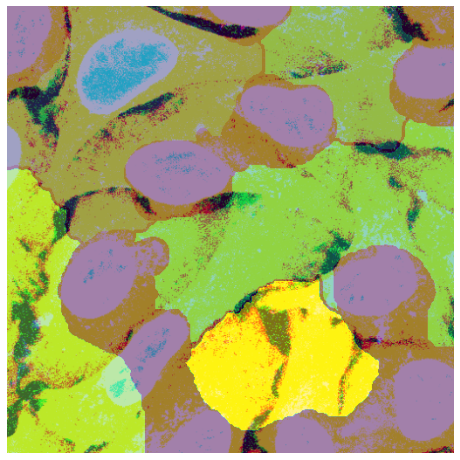

torch.Size([4, 512, 512]) 0


In [155]:
tmp_dataset = SegmentedProteinDataset(
    img_dir="/workspace/Kaggle/HPA/hpa_2020/inference/test/images_768",
    img_size=768,
    return_label=False,
    in_channels=4,
    transform=None,
    crop_size=512,
    random_crop=True,
)
tmpiter = iter(tmp_dataset)
tmp_img, tmp_mask, tmp_index = next(tmpiter)
print(tmp_img.shape, tmp_index)

In [158]:
np.min(tmp_mask), np.max(tmp_mask)

(0, 5)

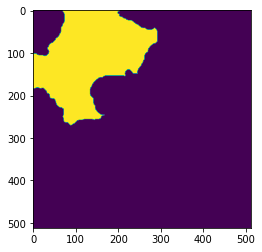

In [159]:
tmp = np.copy(tmp_mask)
tmp[tmp != 1] = 0
plt.imshow(tmp)

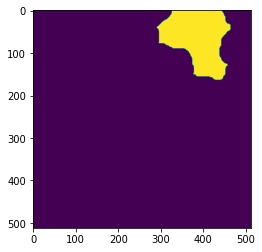

In [160]:
tmp = np.copy(tmp_mask)
tmp[tmp != 2] = 0
plt.imshow(tmp)

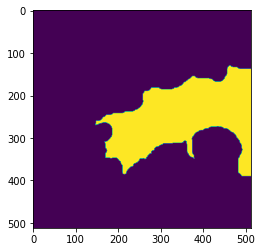

In [161]:
tmp = np.copy(tmp_mask)
tmp[tmp != 3] = 0
plt.imshow(tmp)

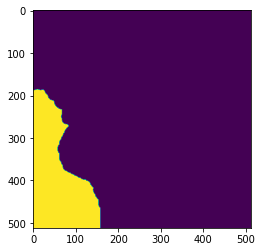

In [162]:
tmp = np.copy(tmp_mask)
tmp[tmp != 4] = 0
plt.imshow(tmp)

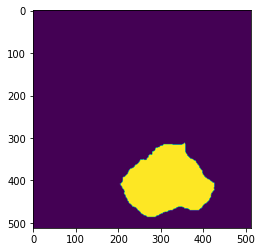

In [163]:
tmp = np.copy(tmp_mask)
tmp[tmp != 5] = 0
plt.imshow(tmp)

In [43]:
# Based on https://github.com/CellProfiling/HPA-competition-solutions/tree/master/bestfitting


class HPATestDataset(torch.utils.data.Dataset):
    def __init__(self,
                 image_folder,
                 img_size=768,
                 crop_size=512,
                 transform=None):
        self.img_size = img_size
        self.crop_size = crop_size
        self.transform = transform

        print(f"{len(self.image_files)} images for inference")

        mt = glob.glob(save_dir + '/' + '*_red.png')
        er = [f.replace('red', 'yellow') for f in mt]
        nu = [f.replace('red', 'blue') for f in mt]
        protein = [f.replace('red', 'green') for f in mt]
        self.image_files = [mt, er, nu]

        # Extract cell masks from each image
        self.images = []
        for mt, er, nu in self.image_files:
            red_image = self.convert(image_path, self.img_size)
            yellow_image = self.convert(image_path, self.img_size)
            blue_image = self.convert(image_path, self.img_size)
            green_image = self.convert(image_path, self.img_size)

        # NUC_MODEL = "/workspace/Kaggle/HPA/nuclei-model.pth"
        # CELL_MODEL = "/workspace/Kaggle/HPA/cell-model.pth"
        NUC_MODEL = "./nuclei-model.pth"
        CELL_MODEL = "./cell-model.pth"
        segmentator = cellsegmentator.CellSegmentator(
            NUC_MODEL,
            CELL_MODEL,
            scale_factor=0.25,
            device="cuda",
            padding=False,
            multi_channel_model=True,
        )

        # For nuclei
        nuc_segmentations = segmentator.pred_nuclei([images[2, :, :]])

        # For full cells
        cell_segmentations = segmentator.pred_cells(images)

        # post-processing
        for i, pred in enumerate(cell_segmentations):
            nuclei_mask, cell_mask = label_cell(nuc_segmentations[i],
                                                cell_segmentations[i])

    def convert(self, image_path, size):
        image = np.array(Image.open(image_path), dtype=np.float32)
        print(image.shape)

        # Resize
        image = cv2.resize(image, (size, size), interpolation=cv2.INTER_LINEAR)
        return image

    def read_crop_img(self, img):
        random_crop_size = int(np.random.uniform(self.crop_size,
                                                 self.img_size))
        x = int(np.random.uniform(0, self.img_size - random_crop_size))
        y = int(np.random.uniform(0, self.img_size - random_crop_size))
        crop_img = img[x:x + random_crop_size, y:y + random_crop_size]
        return crop_img

    def read_rgby(self, img_dir, img_id, index):
        if self.is_external[index]:
            img_is_external = True
        else:
            img_is_external = False

        colors = ['red', 'green', 'blue', 'yellow']
        flags = cv2.IMREAD_GRAYSCALE
        img = [
            cv2.imread(opj(img_dir, img_id + '_' + color + suffix), flags)
            for color in colors
        ]
        img = np.stack(img, axis=-1)
        if self.random_crop and self.crop_size > 0:
            img = self.read_crop_img(img)
        return img

    def __getitem__(self, index):
        image_path = self.image_files[index]

        image = self.convert(image_path, self.img_size)
        return {"x": image, "y": -1}

    def __len__(self):
        return len(self.image_files)

In [59]:
# tmp = HPATestDataset(test_image_folder)
# next(iter(tmp))

## Load Pretrained Model from Bestfitting

In [ ]:
datasets_names = ['test', 'val']
split_names = ['random_ext_folds5', 'random_ext_noleak_clean_folds5']
augment_list = ['default', 'flipud', 'fliplr','transpose', 'flipud_lr',
                'flipud_transpose', 'fliplr_transpose', 'flipud_lr_transpose']

parser = argparse.ArgumentParser(description='PyTorch Protein Classification')
parser.add_argument('--out_dir', type=str, help='destination where predicted result should be saved')
parser.add_argument('--gpu_id', default='0', type=str, help='gpu id used for predicting (default: 0)')
parser.add_argument('--arch', default='class_densenet121_dropout', type=str,
                    help='model architecture (default: class_densenet121_dropout)')
parser.add_argument('--num_classes', default=28, type=int, help='number of classes (default: 28)')
parser.add_argument('--in_channels', default=4, type=int, help='in channels (default: 4)')
parser.add_argument('--img_size', default=768, type=int, help='image size (default: 768)')
parser.add_argument('--crop_size', default=512, type=int, help='crop size (default: 512)')
parser.add_argument('--batch_size', default=32, type=int, help='train mini-batch size (default: 32)')
parser.add_argument('--workers', default=3, type=int, help='number of data loading workers (default: 3)')
parser.add_argument('--fold', default=0, type=int, help='index of fold (default: 0)')
parser.add_argument('--augment', default='default', type=str, help='test augmentation (default: default)')
parser.add_argument('--seed', default=100, type=int, help='random seed (default: 100)')
parser.add_argument('--seeds', default=None, type=str, help='predict seed')
parser.add_argument('--dataset', default='test', type=str, choices=datasets_names,
                    help='dataset options: ' + ' | '.join(datasets_names) + ' (default: test)')
parser.add_argument('--split_name', default='random_ext_folds5', type=str, choices=split_names,
                    help='split name options: ' + ' | '.join(split_names) + ' (default: random_ext_folds5)')
parser.add_argument('--predict_epoch', default=None, type=int, help='number epoch to predict')

In [ ]:
test_dataset_path = "/workspace/Kaggle/HPA/hpa_2020/test"
args = parser.parse_args([
    "--out_dir", "external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds",
    "--gpu_id", "0",
    "--arch", "class_densenet121_dropout",
    "--img_size", "768",
    "--crop_size", "512",
    "--seeds", "1120",
    "--batch_size", "8",
    "--fold", "0",
    "--dataset", "test"
])
args

In [ ]:
# args.predict_epoch = 'final' if args.predict_epoch is None else '%03d' % args.predict_epoch
# network_path = opj(RESULT_DIR, 'models', args.out_dir, 'fold%d' % args.fold,
#                    '%s.pth' % args.predict_epoch)
network_path = f"{bestfitting_folder}/external_crop512_focal_slov_hardlog_class_densenet121_dropout_i768_aug2_5folds/fold0/final.pth"

# setting up the visible GPU
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu_id

model_params = {}
model_params['architecture'] = args.arch
model_params['num_classes'] = args.num_classes
model_params['in_channels'] = args.in_channels
model = init_network(model_params)

# log.write(">> Loading network:\n>>>> '{}'\n".format(network_path))
checkpoint = torch.load(network_path)
model.load_state_dict(checkpoint['state_dict'])
# log.write(">>>> loaded network:\n>>>> epoch {}\n".format(checkpoint['epoch']))

# moving network to gpu and eval mode
# model = DataParallel(model)
model.cuda()
model.eval()

In [ ]:
def predict(test_loader, model, submit_out_dir, dataset):
    all_probs = []
    img_ids = np.array(test_loader.dataset.img_ids)
    for it, iter_data in tqdm(enumerate(test_loader, 0),
                              total=len(test_loader)):
        images, indices = iter_data
        images = Variable(images.cuda(), volatile=True)
        outputs = model(images)
        logits = outputs

        probs = F.sigmoid(logits).data
        all_probs += probs.cpu().numpy().tolist()
    img_ids = img_ids[:len(all_probs)]
    all_probs = np.array(all_probs).reshape(len(img_ids), -1)

    np.save(opj(submit_out_dir, 'prob_%s.npy' % dataset), all_probs)

    result_df = prob_to_result(all_probs, img_ids)
    result_df.to_csv(opj(submit_out_dir, 'results_%s.csv.gz' % dataset),
                     index=False,
                     compression='gzip')


def prob_to_result(probs, img_ids, th=0.5):
    probs = probs.copy()
    probs[np.arange(len(probs)), np.argmax(probs, axis=1)] = 1

    pred_list = []
    for line in probs:
        s = ' '.join(list([str(i) for i in np.nonzero(line > th)[0]]))
        pred_list.append(s)
    result_df = pd.DataFrame({ID: img_ids, PREDICTED: pred_list})
    return result_df

In [ ]:
# Data loading code
dataset = args.dataset
# if dataset == 'test':
#     test_split_file = opj(DATA_DIR, 'split', 'test_11702.csv')
# elif dataset == 'val':
#     test_split_file = opj(DATA_DIR, 'split', args.split_name, 'random_valid_cv%d.csv' % args.fold)
# else:
#     raise ValueError('Unsupported or unknown dataset: {}!'.format(dataset))
test_split_file = "/workspace/Kaggle/HPA/hpa_2020/sample_submission.csv"


test_dataset = ProteinDataset(
    test_split_file,
    img_size=args.img_size,
    is_trainset=(dataset != 'test'),
    return_label=False,
    in_channels=args.in_channels,
    transform=None,
    crop_size=args.crop_size,
    random_crop=False,
)
test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=args.batch_size,
    drop_last=False,
    num_workers=args.workers,
    pin_memory=True,
)

In [ ]:
seeds = [args.seed] if args.seeds is None else [int(i) for i in args.seeds.split(',')]
for seed in seeds:
    test_dataset.random_crop = (seed != 0)
    for augment in args.augment:
        test_loader.dataset.transform = eval('augment_%s' % augment)
        if args.crop_size > 0:
            sub_submit_out_dir = opj(submit_out_dir, '%s_seed%d' % (augment, seed))
        else:
            sub_submit_out_dir = opj(submit_out_dir, augment)
        if not ope(sub_submit_out_dir):
            os.makedirs(sub_submit_out_dir)
        with torch.no_grad():
            predict(test_loader, model, sub_submit_out_dir, dataset)

In [ ]:
# !ls /workspace/Kaggle/HPA/hpa_2020/inference/test/images_768

In [ ]:
import hpacellseg.cellsegmentator as cellsegmentator
from hpacellseg.utils import label_cell, label_nuclei
import glob

mt = glob.glob(test_image_folder + '/' + '*_red.png')
er = [f.replace('red', 'yellow') for f in mt]
nu = [f.replace('red', 'blue') for f in mt]
images = [mt, er, nu]

NUC_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_nuclei_v1.pth"
CELL_MODEL = "/workspace/Github/HPA-Cell-Segmentation/dpn_unet_cell_3ch_v1.pth"
# NUC_MODEL = "/workspace/Kaggle/HPA/nuclei-model.pth"
# CELL_MODEL = "/workspace/Kaggle/HPA/cell-model.pth"
# NUC_MODEL = "./nuclei-model.pth"
# CELL_MODEL = "./cell-model.pth"
segmentator = cellsegmentator.CellSegmentator(
    NUC_MODEL,
    CELL_MODEL,
    scale_factor=0.25,
    device="cuda",
    padding=True,
    multi_channel_model=True,
)

# For nuclei
nuc_segmentations = segmentator.pred_nuclei(images[2])8/7

# For full cells
cell_segmentations = segmentator.pred_cells(images)

# post-processing
for i, pred in enumerate(cell_segmentations):
    nuclei_mask, cell_mask = label_cell(nuc_segmentations[i],
                                        cell_segmentations[i])
    FOVname = os.path.basename(mt[i]).replace('red', 'predictedmask')
    imageio.imwrite(os.path.join(save_dir, FOVname), cell_mask)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### EOF